In [168]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from util.functions import get_data_ticker, gerar_dias_uteis, decompor_sinal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import keras
from keras.layers import Input, LSTM, Dense, Dropout
from keras import Sequential


### Parâmetros

In [238]:
EMPRESA = 'ITUB4.SA'
SEED = 1
qtdTreino = .8

# features = ['Close', 'prev-day-1', 'prev-day-2', 'prev-day-3', 'mm_5', 'mm_21', 'Close_diff']
features = ['Close','Close_diff', 'mm_5', 'mm_21']
features_trend = ['Close','tomorrow']
target = 'tomorrow'

n_past = 15
days_to_predict = 10
# n_features = len(features)

np.random.seed(SEED)
tf.random.set_seed(SEED)

### Funções

In [239]:
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

In [240]:
def prepare_new_record(df, new_record, date_index, rolling=1):
    data_orig = pd.DataFrame({'Close': new_record}, index=[date_index])
    data_orig = data_orig.rename_axis('Date')
    data_orig = pd.concat([df,data_orig])
    data_hist = pd.DataFrame(data_orig['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].rolling(rolling).mean().shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].rolling(rolling).mean().shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].rolling(rolling).mean().shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist['tomorrow'] = data_hist['Close'].rolling(rolling).mean().shift(-1)
    data_hist['Close_diff'] = data_hist['Close'].diff().dropna()
    data_hist['tomorrow'].fillna(0, inplace = True)
    return data_hist.tail(1)

In [241]:
def increment_data_df(df, last_predict, offset=0):
   if df.tail(1)['tomorrow'].values[0] == 0:
      return df
   dia_util = gerar_dias_uteis(1, offset)[0]
   return pd.concat([df, prepare_new_record(df, last_predict, dia_util)])

In [242]:
def evaluate_model(y_true, y_pred):
    # Calcular as métricas de desempenho
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Criar um dicionário com as métricas
    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }
    
    return metrics

In [243]:
def aplicar_tendencia_coluna(df, coluna, period = 120):
    season = decompor_sinal(df[coluna], period=period )
    tendencia = season.trend
    tendencia.dropna()
    df.loc[tendencia.dropna().index].copy()
    df[coluna] = tendencia

## Obter dados

In [244]:
dados = get_data_ticker(EMPRESA, period='5y', dropna=False)
dados['Close_diff'] = dados['Close'].diff().dropna()

dados.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


## Decomposição

### Análises para descobrir o melhor "period"

#### ACF

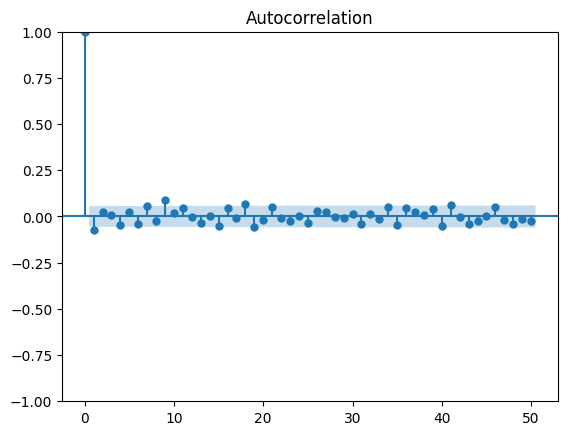

In [245]:
plot_acf(dados['Close_diff'], lags=50) 
plt.show()

### Seasonal decompose

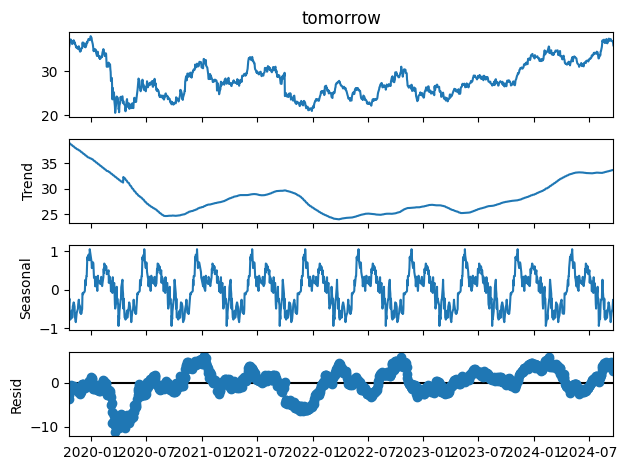

In [246]:
if 'tomorrow' in features_trend:
    season = decompor_sinal(dados['tomorrow'], period=120 )
    tendencia = season.trend

    season.plot()
    plt.show()

## Pré processamento

In [247]:
for f in features_trend:
    aplicar_tendencia_coluna(dados, f)

In [248]:
fig = px.line(dados, y=['mm_5', 'mm_21', 'Close', 'tomorrow'])
fig.update_layout(
    title=dict(text="médias móveis X tendencia", font=dict(size=50), automargin=True, yref='paper')
)
fig.show()

Separando dados de treino e teste

In [249]:
def split_X_y(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), index=df.index, columns=features)
    X, y = create_sequences(df_scaled[features].values, df[target].values, n_past)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=qtdTreino, shuffle=False)
    return (X, y, X_train, X_test, y_train, y_test)

In [250]:
X, y, X_train, X_test, y_train, y_test = split_X_y(dados)

In [251]:
if 'Close' in features:
    close_index = features.index('Close')

    close_values= [X_train[i, :, close_index] for i in range(X_train.shape[0])]
    X_train_plot = [arr[0] for arr in close_values]

    close_values= [X_test[i, :, close_index] for i in range(X_test.shape[0])]
    X_test_plot = [arr[0] for arr in close_values]


In [252]:

dtr_plot = pd.DataFrame({'tomorrow':y_train})
dte_plot = pd.DataFrame({'tomorrow':y_test})
dtr_plot['tipo'] = 'treino'
dte_plot['tipo'] = 'teste'

# Adicionar índices sequenciais
dtr_plot['index'] = range(len(dtr_plot))
dte_plot['index'] = range(len(dtr_plot), len(dtr_plot) + len(dte_plot))

# Concatenar os DataFrames
dados_concat = pd.concat([dtr_plot, dte_plot])

# Criar o gráfico
fig = px.line(dados_concat, x='index', y='tomorrow', color='tipo')

# Atualizar o layout do gráfico
fig.update_layout(
    title=dict(text="Split treino X teste", font=dict(size=50), automargin=True, yref='paper'),
    xaxis_title='Índice',
    yaxis_title='Valor de Fechamento'
)

# Exibir o gráfico
fig.show()

## Modelos

### Prophet

In [253]:
np.random.seed(42)

df_prophet = pd.DataFrame()
df_prophet['ds'] = dados.index
df_prophet['y'] = dados['Close'].reset_index(drop=True)

tamanho_treino = int(len(df_prophet)*.8)
tamanho_teste = int(len(df_prophet)*.2)

df_treino = df_prophet[:tamanho_treino]
df_teste = df_prophet[tamanho_treino:]

modelo_prophet = Prophet()
modelo_prophet.fit(df_treino)

futuro = modelo_prophet.make_future_dataframe(periods=len(df_teste), freq='D')
previsao = modelo_prophet.predict(futuro)

00:37:06 - cmdstanpy - INFO - Chain [1] start processing
00:37:07 - cmdstanpy - INFO - Chain [1] done processing


MSE: 8.49; RMSE: 2.91


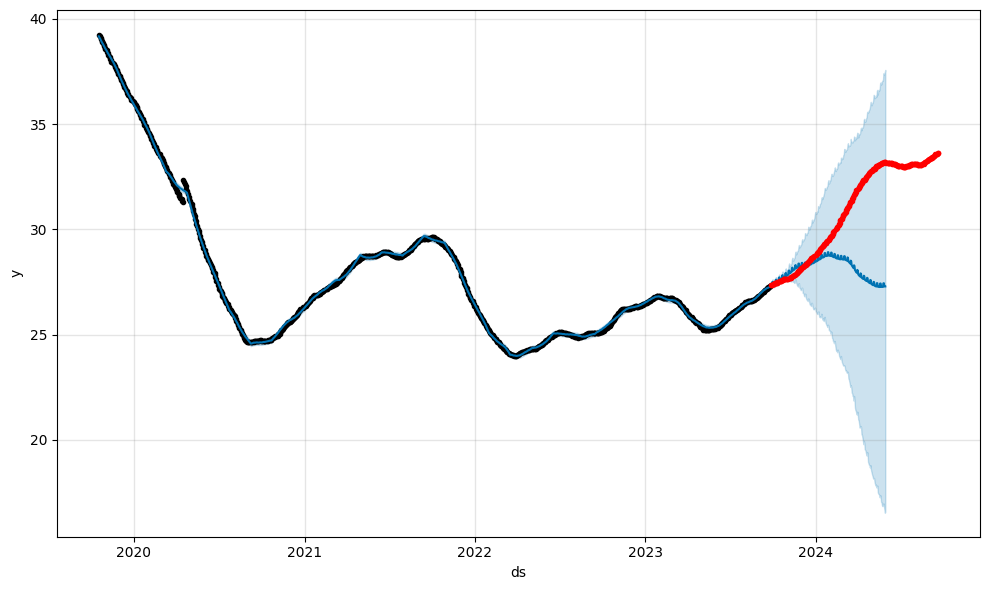

In [254]:
modelo_prophet.plot(previsao)

plt.plot(df_teste['ds'],df_teste['y'],'.r')

from sklearn.metrics import mean_squared_error

df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste, on='ds', how='inner')

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)
print(f'MSE: {mse}; RMSE: {rmse}')

In [255]:
# modelo_prophet = Prophet()
# modelo_prophet.fit(df_prophet)

# futuro = modelo_prophet.make_future_dataframe(periods=0, freq='D')
# previsao = modelo_prophet.predict(futuro)

# df_prophet_sem_outliers = df_prophet[(df_prophet['y'] > previsao['yhat_lower']) & (df_prophet['y'] < previsao['yhat_upper'])]

# modelo_prophet.plot()

### LSTM

#### Criação do modelo

In [260]:
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(X_train.shape[1], X_train.shape[2]), name='Input'))
modelo_lstm.add(LSTM(240, name='LSTM'))
modelo_lstm.add(Dense(50, activation='relu', name='Dense_50_1'))
modelo_lstm.add(Dense(100, activation='relu',name='Dense_50_2'))
modelo_lstm.add(Dense(20, activation='relu',name='Dense_50_3'))
modelo_lstm.add(Dense(units=1, name='Output'))

# utilizar optimizer adam ou RMSProp
modelo_lstm.compile(optimizer='RMSProp', loss='mean_squared_error')

In [261]:
modelo_lstm.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 240)            │       235,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_50_1 (Dense)              │ (None, 50)             │        12,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_50_2 (Dense)              │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_50_3 (Dense)              │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254,391 (993.71 KB)

 Trainable params: 254,391 (993.71 KB)

 Non-trainable params: 0 (0.00 B)

#### Treinamento do modelo

In [262]:
modelo_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=True)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 294.5247 - val_loss: 10.7637
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.7184 - val_loss: 4.7085
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.0977 - val_loss: 9.0712
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.0901 - val_loss: 4.7573
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 12.4863 - val_loss: 12.9515
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 10.2689 - val_loss: 26.4260
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.7051 - val_loss: 1.0287
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7.3444 - val_loss: 0.5908
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.3769 - val_loss: 2.0706
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.7328 - val_loss: 1.0653


#### Predição do modelo

In [263]:
y_pred = modelo_lstm.predict(X_test)
evaluate_model(y_test, y_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


{'MSE': 1.0653031814897207,
 'MAE': 0.7470381491440393,
 'RMSE': 1.0321352534865382}

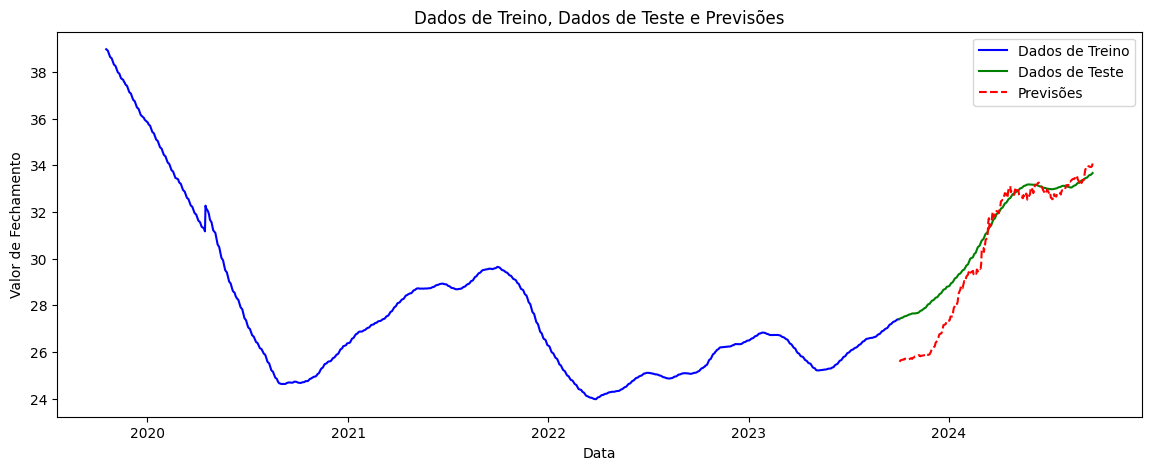

In [264]:
index_train = dados.index[:len(dados) - len(y_test)]
index_test = dados.index[len(dados) - len(y_test):]

# Valores reais de treino e teste
train_values = dados['tomorrow'][:len(dados) - len(y_test)]
test_values = dados['tomorrow'][len(dados) - len(y_test):]

# Plotando o gráfico
plt.figure(figsize=(14, 5))

# Plotando os valores reais de treino
plt.plot(index_train, train_values, color='blue', label='Dados de Treino')

# Plotando os valores reais de teste
plt.plot(index_test, test_values, color='green', label='Dados de Teste')

# Plotando as previsões
plt.plot(index_test, y_pred, color='red', linestyle='--', label='Previsões')

plt.title('Dados de Treino, Dados de Teste e Previsões')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


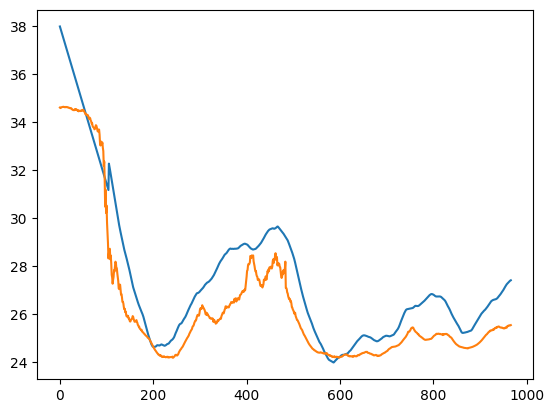

In [265]:
y_pred2 = modelo_lstm.predict(X_train)
plt.plot(y_train)
plt.plot(y_pred2)

In [266]:
dados_forward = dados.copy()
last_pred = y_pred[-1]
feed_preds = []

for d in range(50):
    dados_forward = increment_data_df(dados_forward, y_pred[-1], d)
    X_fwd, y_fwd, X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = split_X_y(dados_forward)
    last_pred = modelo_lstm.predict(X_fwd[-n_past:-1])[-1]

    dados_forward.loc[dados_forward.index[-1], 'tomorrow'] = last_pred
    feed_preds.append(last_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

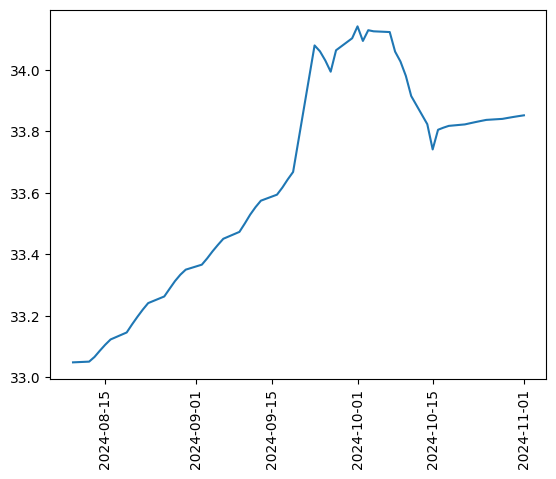

In [267]:
plt.xticks(rotation='vertical')

# plt.plot(dados_forward['tomorrow'][-50:-30])
plt.plot(dados_forward['tomorrow'][-80:-20])

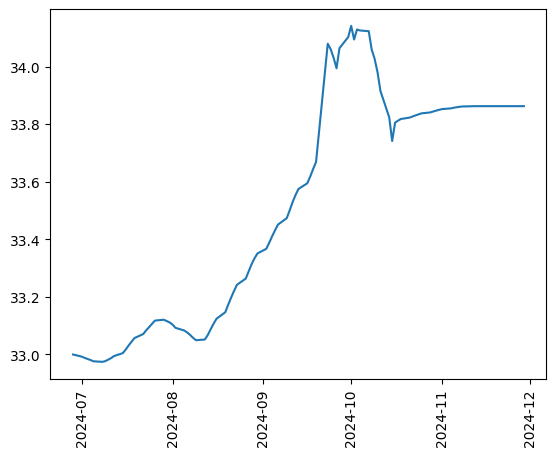

In [268]:
plt.xticks(rotation='vertical')
plt.plot(dados_forward['tomorrow'][-110:])
# dados[-15:-10]
# dados_forward[-10:]